In [1]:
import cv2
import uuid
import os
import time

In [2]:
!pip install labelme albumentations

     ---------------------------------------- 1.5/1.5 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 125.7/125.7 kB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 7.7/7.7 MB 14.9 MB/s eta 0:00:00
  Using cached scikit_image-0.21.0-cp310-cp310-win_amd64.whl (22.8 MB)
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached tifffile-2023.4.12-py3-none-any.whl (219 kB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Created wheel for labelme: filename=labelme-5.2.1-py3-none-any.whl size=1466744 sha256=1a1b6eb3a2e4a230dd1bb2cb2af7ab53ff299aee2b604613a4f3e183b8b0478b
  Stored in directory: c:\users\dellb\appdata\local\pip\cache\wheels\de\44\e2\f05944b4d1af582c7d28ab2d1372a57f63b24576f28a4aa0c3
Successfully built labelme
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.12.0 requires tensorboard<2.13,>=2.12, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.12.0 requires tensorflow-estimator<2.13,>=2.12.0, but you have tensorflow-estimator 2.10.0 which is incompatible.
pandas-profiling 3.5.0 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
tensorflowjs 3.19.0 requires packaging~=20.9, but you have packaging 23.1 which is incompatible.
tensorflowjs 3.19.0 requires protobuf==3.20.0, but you have protobuf 3.19.6 which is incompatible.


### collecting images

In [9]:
IMAGES_PATH=os.path.join("data","images")
num_of_images=30

In [8]:
cap=cv2.VideoCapture(0)

for img_num in range(num_of_images):
    print("Collecting image ",img_num)
    ret,frame=cap.read()
    imgpath=os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg',)
    cv2.imwrite(imgpath,frame)
    cv2.imshow("frame",frame)
    time.sleep(1)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### annotating images with labelMe

In [10]:
!labelme

### Review dataset and build image loading function

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

#### load image into tf data pipeline

In [12]:
images=tf.data.Dataset.list_files("data/images/*.jpg",shuffle=False)

In [14]:
images.as_numpy_iterator().next()

b'data\\images\\92db5336-199a-11ee-89ac-900f0c7ffb34.jpg'

In [15]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [16]:
images=images.map(load_image)

In [18]:
images.as_numpy_iterator().next()

array([[[ 72,  76,  85],
        [ 71,  75,  84],
        [ 70,  74,  85],
        ...,
        [233, 210, 204],
        [232, 209, 203],
        [233, 210, 204]],

       [[ 72,  76,  85],
        [ 71,  75,  84],
        [ 70,  74,  85],
        ...,
        [233, 210, 204],
        [232, 209, 203],
        [233, 210, 204]],

       [[ 70,  77,  85],
        [ 69,  76,  84],
        [ 69,  76,  84],
        ...,
        [234, 209, 204],
        [232, 209, 203],
        [232, 209, 203]],

       ...,

       [[ 69,  68,  66],
        [ 68,  67,  63],
        [ 67,  66,  64],
        ...,
        [148, 129, 122],
        [148, 129, 122],
        [149, 130, 123]],

       [[ 68,  66,  67],
        [ 67,  66,  64],
        [ 66,  66,  66],
        ...,
        [147, 128, 121],
        [147, 128, 121],
        [147, 128, 121]],

       [[ 69,  67,  68],
        [ 69,  67,  68],
        [ 68,  68,  68],
        ...,
        [147, 128, 121],
        [146, 127, 120],
        [146, 127, 120]]

In [19]:
image_generator=images.batch(4).as_numpy_iterator()

In [20]:
plot_images=image_generator.next()

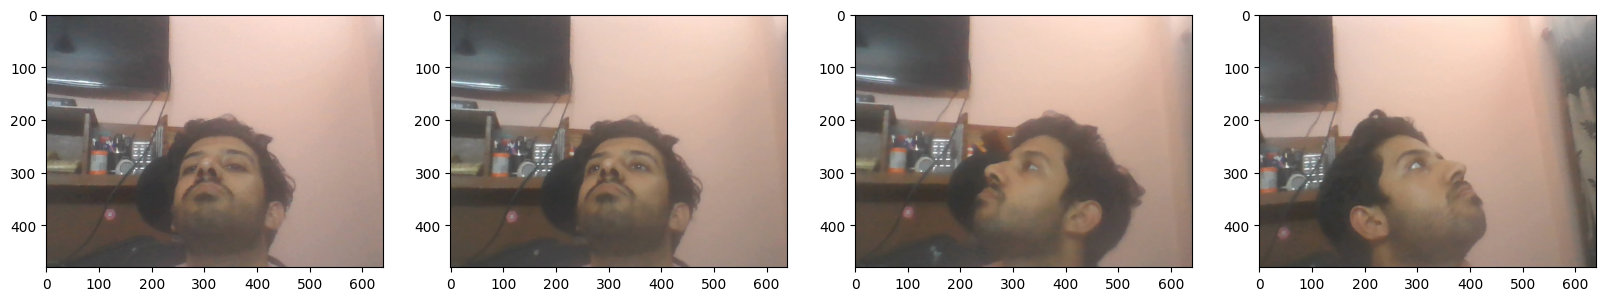

In [23]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [24]:
#### train test split done manually

#### moving matching labels 

In [26]:
for folders in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folders,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath=os.path.join('data',folders,'labels',filename)
            os.replace(existing_filepath,new_filepath)

### apply image augmentation

In [27]:
import albumentations as alb

In [28]:
transform = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels']))

In [32]:
img=cv2.imread(os.path.join('data','train','images','941bed60-199a-11ee-baac-900f0c7ffb34.jpg'))

In [33]:
img

array([[[ 77,  75,  75],
        [ 77,  75,  75],
        [ 75,  75,  75],
        ...,
        [192, 196, 220],
        [191, 195, 219],
        [190, 194, 218]],

       [[ 77,  75,  75],
        [ 77,  75,  75],
        [ 75,  75,  75],
        ...,
        [193, 197, 221],
        [192, 196, 220],
        [191, 195, 219]],

       [[ 75,  75,  75],
        [ 75,  75,  75],
        [ 75,  75,  75],
        ...,
        [191, 197, 220],
        [191, 195, 219],
        [191, 195, 219]],

       ...,

       [[ 62,  64,  65],
        [ 63,  65,  66],
        [ 62,  64,  65],
        ...,
        [106, 115, 142],
        [106, 115, 142],
        [106, 115, 142]],

       [[ 62,  64,  65],
        [ 62,  64,  65],
        [ 62,  64,  65],
        ...,
        [107, 114, 141],
        [107, 114, 141],
        [108, 115, 142]],

       [[ 62,  64,  65],
        [ 62,  64,  65],
        [ 62,  64,  65],
        ...,
        [107, 114, 141],
        [109, 113, 141],
        [109, 113, 141]]

In [36]:
with open(os.path.join('data','train','labels','941bed60-199a-11ee-baac-900f0c7ffb34.json'),'r') as f:
    label=json.load(f)

In [40]:
label['shapes'][0]['label']

'face'

#### extract coordinates and rescale to match image resolution

In [47]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][1][0]
coords[1]=label['shapes'][0]['points'][1][1]
coords[2]=label['shapes'][0]['points'][0][0]
coords[3]=label['shapes'][0]['points'][0][1]

In [48]:
coords

[227.40740740740742, 249.7883597883598, 382.4338624338625, 437.6190476190476]

In [49]:
coords=list(np.divide(coords,[640,480,640,480]))

In [50]:
coords

[0.35532407407407407,
 0.5203924162257496,
 0.5975529100529101,
 0.9117063492063492]

#### apply augmentation

In [51]:
augmented=transform(image=img,bboxes=[coords],class_labels=['face'])

In [52]:
augmented

{'image': array([[[212, 225, 253],
         [212, 225, 253],
         [213, 226, 254],
         ...,
         [ 95,  90,  91],
         [ 95,  90,  91],
         [ 95,  90,  91]],
 
        [[210, 225, 253],
         [210, 225, 253],
         [210, 225, 253],
         ...,
         [ 95,  90,  91],
         [ 96,  92,  91],
         [ 97,  93,  92]],
 
        [[209, 224, 252],
         [209, 224, 252],
         [210, 225, 253],
         ...,
         [ 96,  91,  92],
         [ 96,  92,  91],
         [ 96,  92,  91]],
 
        ...,
 
        [[140, 151, 171],
         [141, 152, 172],
         [141, 152, 172],
         ...,
         [ 79,  79,  79],
         [ 78,  78,  78],
         [ 79,  79,  79]],
 
        [[140, 151, 171],
         [140, 151, 171],
         [140, 151, 171],
         ...,
         [ 79,  79,  79],
         [ 78,  78,  78],
         [ 79,  79,  79]],
 
        [[139, 151, 171],
         [139, 151, 171],
         [140, 151, 171],
         ...,
         [ 79,  79,

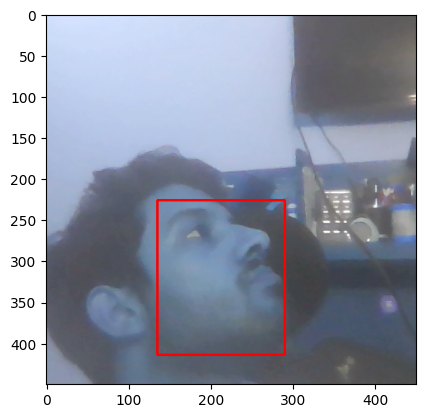

In [55]:
cv2.rectangle(augmented['image'],tuple(np.multiply(augmented['bboxes'][0][0:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)), (255,0,0),2)
plt.imshow(augmented['image'])

### augmentation pipeline

In [81]:
for folder in ['train','test','val']:
    for image in os.listdir(os.path.join('data',folder,'images')):
        img =cv2.imread(os.path.join('data',folder,'images',image))
        coords=[0,0,0.00001,0.00001]
        label_path=os.path.join('data',folder,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label=json.load(f)
                
            if (label['shapes'][0]['points'][1][0])<(label['shapes'][0]['points'][0][0]):
                coords[0]=label['shapes'][0]['points'][1][0]
                coords[1]=label['shapes'][0]['points'][1][1]
                coords[2]=label['shapes'][0]['points'][0][0]
                coords[3]=label['shapes'][0]['points'][0][1]
            else:
                coords[0]=label['shapes'][0]['points'][0][0]
                coords[1]=label['shapes'][0]['points'][0][1]
                coords[2]=label['shapes'][0]['points'][1][0]
                coords[3]=label['shapes'][0]['points'][1][1]
            coords=list(np.divide(coords,[640,480,640,480]))
            
        for i in range(60):
            augmented=transform(image=img,bboxes=[coords],class_labels=['face'])
            cv2.imwrite(os.path.join('aug_data',folder,'images',f'{image.split(".")[0]}.{i}.jpg'),augmented['image'])
            
            annotations={}
            annotations['image']=image
            
            if(os.path.exists(label_path)):
                if len(augmented['bboxes'])==0:
                    annotations['bboxes']=[0,0,0,0]
                    annotations['class']=0
                else:
                    annotations['bboxes']=augmented['bboxes'][0]
                    annotations['class']=1
            else:
                annotations['bboxes']=[0,0,0,0]
                annotations['class']=0
            
            with open(os.path.join('aug_data',folder,'labels',f'{image.split(".")[0]}.{i}.json'),'w') as f:
                json.dump(annotations,f)

#### load augmented images into tensorlfow dataset

In [86]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [87]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [88]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

### preparing labels

In [83]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding='utf-8') as f:
        label=json.load(f)
    
    return [label['class'],label['bboxes']]

In [94]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [95]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [96]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [98]:
train_labels.as_numpy_iterator().next()

(1, array([0.3635, 0.0897, 0.708 , 0.5073], dtype=float16))

### combine image and labels

In [99]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(1200, 1200, 300, 300, 300, 300)

#### create final datasets

In [101]:
train=tf.data.Dataset.zip((train_images,train_labels))
train=train.shuffle(3000)
train=train.batch(8)
train=train.prefetch(4)

In [102]:
test=tf.data.Dataset.zip((test_images,test_labels))
test=test.shuffle(3000)
test=test.batch(8)
test=test.prefetch(4)

In [103]:
val=tf.data.Dataset.zip((val_images,val_labels))
val=val.shuffle(3000)
val=val.batch(8)
val=val.prefetch(4)

In [104]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

#### view images

In [105]:
data_samples=train.as_numpy_iterator()

In [109]:
res=data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


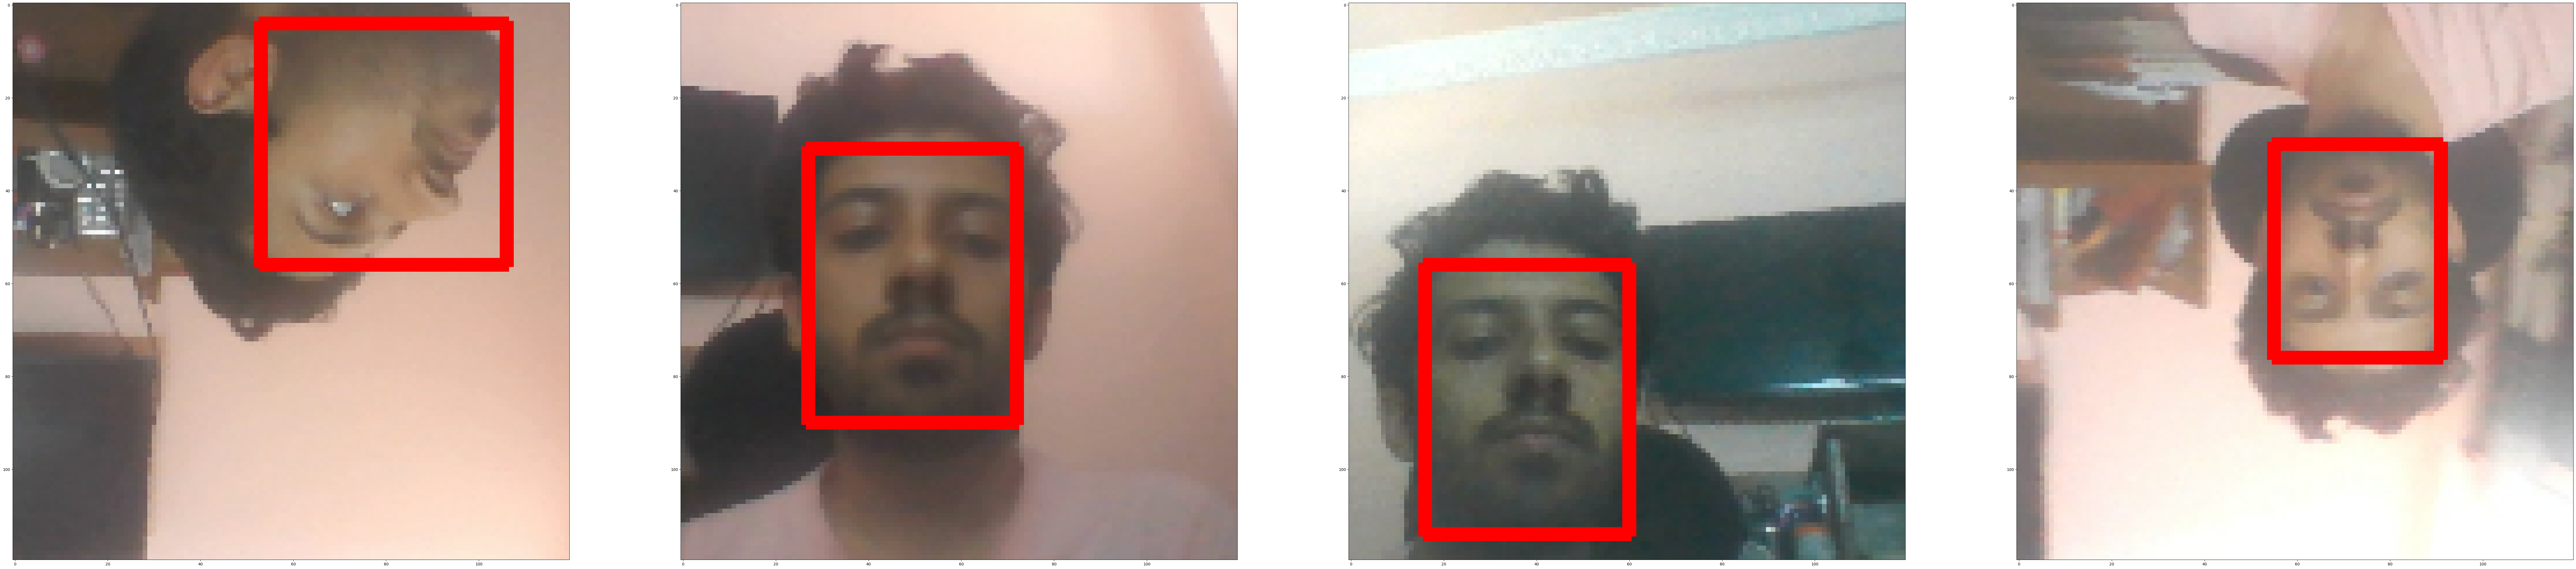

In [110]:
fig,ax=plt.subplots(ncols=4,figsize=(120,120))
for idx in range(4):
    sample_image=res[0][idx]
    sample_coords=res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                 (255,0,0),2)
    ax[idx].imshow(sample_image)